In [84]:
%load_ext autoreload
%autoreload 2

import joblib
from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles, addMarketFeatures_toSamples

from agents.RL_Agent_Base import RLAgent_Base
from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent
from Runs.train_agents import trainer_BatchTree, trainer_QTable
# from Runs.train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocess Data

In [85]:
hist = pd.read_csv('ob_features70000_1611_1705_level2data.csv', index_col=0, parse_dates=[0])

In [ ]:
data_may = pickle.load( open( '../cached_windows_60mins_V200/obs_2017-05_USDT_BTC_maxVol200.p', "rb" ) )

### Source Agent

In [86]:
folder = 'trainedAgents/longterm_apr_BT'
# agent_name = 'BT_Agent_samples43268'

folder = 'trainedAgents/longterm_1611_1704_simulate_preceeding_trades/'
agent_name = 'QTable_1611-1704_T4_I8_VolTime'

agent_source = RLAgent_Base.load(agent_name=agent_name, path=folder)
print(agent_source.agent_type)
print(agent_source.state_variables)
print(agent_source)

QTable_Agent
['volume', 'time']
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611-1704_T4_I8_VolTime', state_variables: '['volume', 'time']'


In [87]:
new_agent = agent_source.convert_to_BatchTreeAgent(
    new_name='BT_VolTime_depth8apr', 
    state_variables=['volume', 'time']  #, '_a_4']
)

In [80]:
new_agent.samples = new_agent.samples[new_agent.samples.timestamp>'2017-04']
new_agent.samples.shape

(342600, 10)

In [81]:
new_features = ['_a_{}'.format(a) for a in [4]]
print(new_features)
new_agent.samples = addMarketFeatures_toSamples(samples=new_agent.samples, 
                                                hist=hist, 
                                                market_features=new_features,
                                                state_variables=new_agent.state_variables,
                                                fixedMarketVariables=False)

0it [00:00, ?it/s]

['_a_4']
_a_4


1it [00:02,  2.23s/it]


In [82]:
new_agent.agent_name

'BT_VolTime_depth8apr'

In [83]:
new_agent.learn_fromSamples(verbose=True, n_estimators=80, max_depth=8)
new_agent.save(path="trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT", ignore_samples=True)

  0%|          | 0/4 [00:00<?, ?it/s]

x
n 0
fit


,volume,time,_a_4,action
1631040,70000.0,1.0,60516.6709,-4.0
1631041,70000.0,1.0,60516.6709,-3.0
1631042,70000.0,1.0,60516.6709,-2.0
1631043,70000.0,1.0,60516.6709,-1.0
1631044,70000.0,1.0,60516.6709,0.0


1631040    365.508315
1631041    365.508315
1631042    300.151932
1631043    227.544886
1631044    179.308226
Name: min_cost, dtype: float64

fit done


 25%|██▌       | 1/4 [00:18<00:55, 18.53s/it]

Score: 0.28800688273
Feature importances: [ 0.39828925  0.17401154  0.01539449  0.41230472]
n 1
a -4
a -3
a -2
a -1
a 0
a 1
a 2
a 3
a 4
a 5
a 6
a 7
a 8
a 9
a 10
fit


,volume,time,_a_4,action
1631040,70000.0,1.0,60516.6709,-4.0
1631041,70000.0,1.0,60516.6709,-3.0
1631042,70000.0,1.0,60516.6709,-2.0
1631043,70000.0,1.0,60516.6709,-1.0
1631044,70000.0,1.0,60516.6709,0.0


1631040    365.508315
1631041    365.508315
1631042    300.151932
1631043    227.544886
1631044    179.308226
Name: min_cost, dtype: float64

fit done


 50%|█████     | 2/4 [01:24<01:05, 32.70s/it]

Score: 0.280088002026
Feature importances: [ 0.4157348   0.18081982  0.01869114  0.38475424]
n 2
a -4
a -3
a -2
a -1
a 0
a 1
a 2
a 3
a 4
a 5
a 6
a 7
a 8
a 9
a 10
fit


,volume,time,_a_4,action
1631040,70000.0,1.0,60516.6709,-4.0
1631041,70000.0,1.0,60516.6709,-3.0
1631042,70000.0,1.0,60516.6709,-2.0
1631043,70000.0,1.0,60516.6709,-1.0
1631044,70000.0,1.0,60516.6709,0.0


1631040    365.508315
1631041    365.508315
1631042    300.151932
1631043    227.544886
1631044    179.308226
Name: min_cost, dtype: float64

fit done


 75%|███████▌  | 3/4 [02:35<00:44, 44.35s/it]

Score: 0.264351214979
Feature importances: [ 0.4643102   0.16721345  0.01968374  0.34879261]
n 3
a -4
a -3
a -2
a -1
a 0
a 1
a 2
a 3
a 4
a 5
a 6
a 7
a 8
a 9
a 10
fit


,volume,time,_a_4,action
1631040,70000.0,1.0,60516.6709,-4.0
1631041,70000.0,1.0,60516.6709,-3.0
1631042,70000.0,1.0,60516.6709,-2.0
1631043,70000.0,1.0,60516.6709,-1.0
1631044,70000.0,1.0,60516.6709,0.0


1631040    365.508315
1631041    365.508315
1631042    300.151932
1631043    227.544886
1631044    179.308226
Name: min_cost, dtype: float64

fit done


100%|██████████| 4/4 [03:47<00:00, 52.43s/it]

Score: 0.244657406064
Feature importances: [ 0.54222524  0.12570371  0.01817646  0.31389458]
Saved agent: 'trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT/BT_VolTime_depth8apr.json'
Saved model: 'trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT/BT_VolTime_depth8apr.model'
ignoring samples


In [46]:
new_agent.agent_nameame

'BT_VolTimeSpread'

In [19]:
new_agent.agent_name = "BT_VolTime"

In [22]:
new_agent.save(path="trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT", ignore_samples=True)

File 'trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT/BT_VolTime.json' exists! Do not overwrite!
File 'trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT/BT_VolTime.model' exists! Do not overwrite!
ignoring samples


In [88]:
new_agent = RLAgent_Base.load(agent_name="BT_VolTime",
                  path="trainedAgents/longterm_1611_1704_simulate_preceeding_trades/retrained_BT",
                  ignore_samples=True)

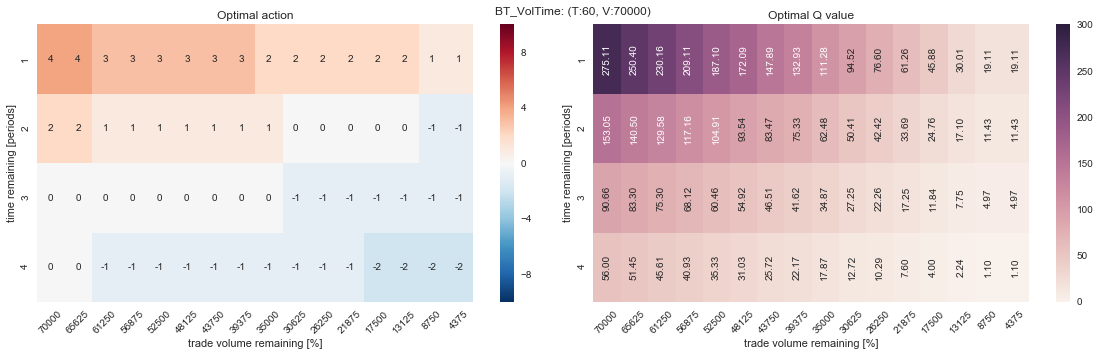

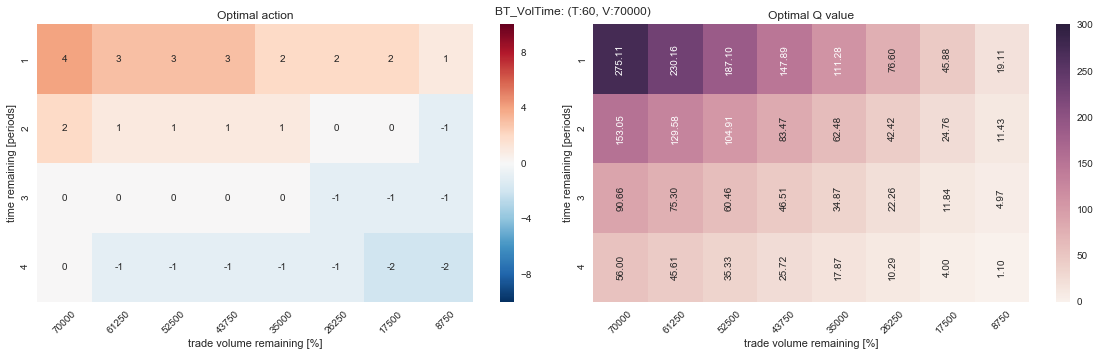

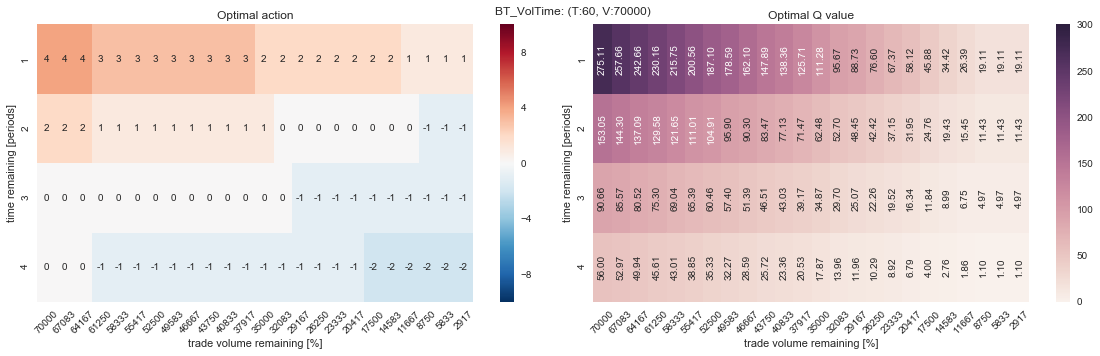

In [89]:
new_agent.heatmap_Q(vol_intervals=16)
new_agent.heatmap_Q(vol_intervals=8)
new_agent.heatmap_Q(vol_intervals=24)

### Train agents

In [ ]:
T=4
P=15
V=70000
consume='cash'
print("T: {}, P: {}, V: {}, consume: '{}'".format(T, P, V, consume))

actions = np.linspace(-0.4, 1.0, num=15)
actions = range(-4,11)
actions = [0, 3, 5, 7]
data = data_dec[:]
print("Trading windows: {} (each one: {} minutes)".format(len(data), len(data[0])))

### Evaluate Agents

In [ ]:
agent_collection = {
    'agent_source': agent_source
}

In [ ]:
data = data_may[120:]
# baseline = 'test_Dec24_VolTime'
baseline = list(agent_collection.keys())[0]
#baseline = 'VolTime'
costs2, slippage2 = evaluate(
    testdata=data,
    agents=agent_collection,  # {'VolTime': agent_collection['VolTime']},
    baseline=baseline,
    evaluate_actions=[2, 4],
    verbose=False
)

display(slippage.describe())


In [ ]:
sli = pd.read_csv('slippage_may_BT36973apr.csv', index_col=0, parse_dates=[0])

In [ ]:
sli.iloc[:640].mean()

##### QTable Agent

In [ ]:
### QTable Agent
data = data_dec
T=4
P=15
agent = trainer_QTable(orderbooks=data[:24], V=V, T=T, consume=consume, actions=[round(a, 2) for a in actions],
                    limit_base='incStepUnits', vol_intervals=4,
                    period_length=P, agent_name='test2_Dec24_VolTime',
                    state_variables=['volume', 'time'], mode='backward')
agent.save(path="trainedAgents", overwrite=True)

In [ ]:
agent.heatmap_Q()

In [ ]:
### QTable Agent
# agent_VolTime = trainer_QTable(orderbooks=data[:1], V=V, T=T, consume=consume, actions=[round(a, 2) for a in actions],
#                     limit_base='incStepUnits', vol_intervals=4,
#                     period_length=P, agent_name='VolTime_Dec0:96_I4',
#                     state_variables=['volume', 'time'], mode='backward')
agent_VolTime.samples = agent.samples
agent_VolTime.learn_fromSamples(reset_brain=True)
agent_VolTime.save(path="trainedAgents", overwrite=True)

In [ ]:
### BatchTree Agent
random.seed(13)
np.random.seed(13)
agent = trainer_BatchTree(orderbooks=data[:1], V=V, T=T, consume=consume, actions=actions,
                    lim_stepsize=0.1, limit_base='incStepUnits',
                    period_length=P, epochs=40, agent_name='BT_60min_VolTimeDir_Dec0:96_nogauss', guiding_agent=None,
                    random_start=False, state_variables=['volume', 'time', 'direction'], mode='forward')
agent.save(path="trainedAgents", overwrite=True)